# Cell Types Database

This notebook demonstrates most of the features of the AllenSDK that help manipulate data in the Cell Types Database.  The main entry point will be through the `CellTypesCache` class.

`CellTypesCache` is responsible for downloading Cell Types Database data to a standard directory structure on your hard drive.  If you use this class, you will not have to keep track of where your data lives, other than a root directory.

Contents:
* <a href='#Cell-Types-Database'>Download and plot stimuli and responses from an NWB file for a cell</a>
* <a href='#Filtering-Cells-via-Metadata'>Filtering Cells via Metadata</a>
* <a href='#Cell-Morphology-Reconstructions'>Download and plot a cell's morphological reconstruction</a>
* <a href='#Electrophysiology-Features'>Download and plot precomputed electrophysiology features</a>
* <a href='#Morphology-Features'>Download precomputed morphology features to a table</a>
* <a href='#Computing-Electrophysiology-Features'>Compute electrophysiology features for a single sweep</a>

Download this file in .ipynb format <a href='cell_types.ipynb'>here</a>.

In [1]:
from allensdk.core.cell_types_cache import CellTypesCache

# Instantiate the CellTypesCache instance.  The manifest_file argument
# tells it where to store the manifest, which is a JSON file that tracks
# file paths.  If you supply a relative path it will go into your
# current working directory
ctc = CellTypesCache()

# this saves the NWB file to 'cell_types/specimen_464212183/ephys.nwb'
cell_specimen_id = 464212183
data_set = ctc.get_ephys_data(cell_specimen_id)

The `data_set` variable is an `NwbDataSet` instance, which has some methods we can use to access the injected current stimulus waveform and the voltage response waveform for all experimental sweeps.  Let's pull one sweep out and plot it.

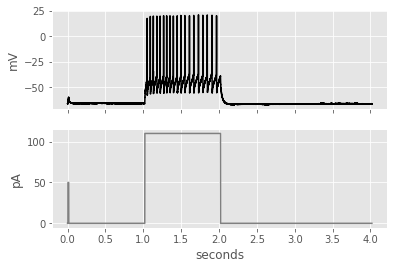

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

sweep_number = 30
sweep_data = data_set.get_sweep(sweep_number)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t, v, color='black')
axes[1].plot(t, i, color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")
plt.show()

## Filtering Cells via Metadata

Cell records in the Cell Types Database come with a large amount of metadata.  We have exposed the most commonly used of these are arguments to CellTypesCache.get_cells.  

In [3]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
from allensdk.core.cell_types_cache import ReporterStatus as RS

# download all cells
cells = ctc.get_cells()
print("Total cells: %d" % len(cells))

# mouse cells
cells = ctc.get_cells(species=[CellTypesApi.MOUSE])
print("Mouse cells: %d" % len(cells))

# human cells
cells = ctc.get_cells(species=[CellTypesApi.HUMAN])
print("Human cells: %d" % len(cells))

# cells with reconstructions
cells = ctc.get_cells(require_reconstruction = True)
print("Cells with reconstructions: %d" % len(cells))

# all cre positive cells
cells = ctc.get_cells(reporter_status = RS.POSITIVE)
print("Cre-positive cells: %d" % len(cells))

# cre negative cells with reconstructions
cells = ctc.get_cells(require_reconstruction = True, 
                      reporter_status = RS.NEGATIVE)
print("Cre-negative cells with reconstructions: %d" % len(cells))

Total cells: 2331
Mouse cells: 1920
Human cells: 411
Cells with reconstructions: 637
Cre-positive cells: 1815
Cre-negative cells with reconstructions: 38


## Cell Morphology Reconstructions

The Cell Types Database also contains 3D reconstructions of neuronal morphologies. The data are presented in the SWC format. We'll download a particular cell's reconstrution here.

The AllenSDK contains a module that makes it easier to work with the SWC files. We'll see how the data is contained in the file by looking at the first node.

In [4]:
import pprint

# download and open an SWC file
cell_id = 480114344
morphology = ctc.get_reconstruction(cell_id) 

# the compartment list has all of the nodes in the file
pprint.pprint(morphology.compartment_list[0])

{'children': [1,
              1763,
              2012,
              2089,
              2421,
              2604,
              2821,
              3147,
              3440,
              3491,
              3552,
              4015],
 'id': 0,
 'parent': -1,
 'radius': 7.6078,
 'tree_id': 0,
 'type': 1,
 'x': 444.3296,
 'y': 503.0168,
 'z': 31.92}


Note that the `type` field refers to the type of neuronal compartment. The values can be 1 for the soma, 2 for the axon, 3 for dendrites, and 4 for apical dendrites (if present).

Morphologies now also come with marker files, which contains points of interest in the reconstruction.  The marker file contains locations where dendrites have been truncated due to slicing and when axons were not reconstructed.  The `name` field indicates the type of marker (10 for dendrite truncation, 20 for no reconstruction).

In [5]:
# download and open a marker file
markers = ctc.get_reconstruction_markers(cell_id) 
pprint.pprint(markers[0])

{'name': 10, 'x': 527.5029999999999, 'y': 496.4319, 'z': 12.4555}


We can use this data to draw lines between each node and all its children to get a drawing of the cell. We'll do it looking at it from the front and from the side.

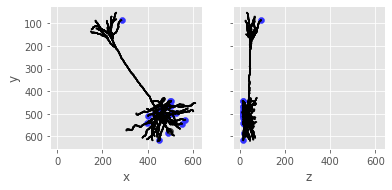

In [6]:
from allensdk.core.swc import Marker
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

# Make a line drawing of x-y and y-z views
for n in morphology.compartment_list:
    for c in morphology.children_of(n):
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color='black')
        axes[1].plot([n['z'], c['z']], [n['y'], c['y']], color='black')

# cut dendrite markers
dm = [ m for m in markers if m['name'] == Marker.CUT_DENDRITE ]

axes[0].scatter([m['x'] for m in dm], [m['y'] for m in dm], color='#3333ff')
axes[1].scatter([m['z'] for m in dm], [m['y'] for m in dm], color='#3333ff')

# no reconstruction markers
nm = [ m for m in markers if m['name'] == Marker.NO_RECONSTRUCTION ]

axes[0].scatter([m['x'] for m in nm], [m['y'] for m in nm], color='#333333')
axes[1].scatter([m['z'] for m in nm], [m['y'] for m in nm], color='#333333')

axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')

# Flip the reconstruction upside down
plt.gca().invert_yaxis()

plt.show()

## Electrophysiology Features

The Cell Types Database contains a set of features that have already been computed, which could serve as good starting points for analysis. We can query the database using the SDK to get these features.

In [7]:
import pandas as pd

# download all electrophysiology features for all cells
ephys_features = ctc.get_ephys_features()
ef_df = pd.DataFrame(ephys_features)

print("Ephys. features available for %d cells" % len(ef_df))

# filter down to a specific cell
specimen_id = 464212183
cell_ephys_features = ef_df[ef_df['specimen_id']== specimen_id]
cell_ephys_features

Ephys. features available for 2333 cells


,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
1129,0.01066,50.912222,-73.090617,0.385991,1.243575,3.872615,1.025798,-58.406254,-56.364585,-61.026044,...,3.87297,1.273295,-58.59375,-56.635419,-65.729168,1.915684,2.045541,1.821178,-90.46875,-65.771713


That's how to get all the ephys features for a given specimen - what if we want a particular feature for all cells?

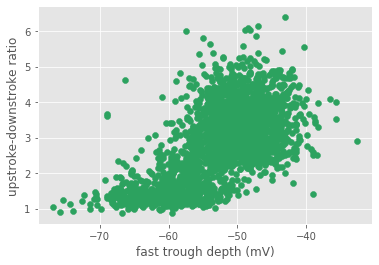

In [8]:
plt.figure()
plt.scatter(ef_df['fast_trough_v_long_square'], 
            ef_df['upstroke_downstroke_ratio_long_square'], color='#2ca25f')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")
plt.show()

Let's use numpy to fit a regression line to these data and plot it.

First 5 rows of A:
[[-56.37500381   1.        ]
 [-54.           1.        ]
 [-59.5          1.        ]
 [-47.53125      1.        ]
 [-48.43750381   1.        ]]
m 0.10468807187601809 c 8.355078903861312


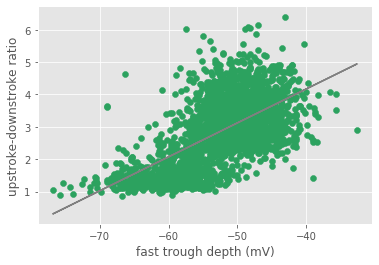

In [9]:
A = np.vstack([ef_df['fast_trough_v_long_square'], 
               np.ones_like(ef_df['upstroke_downstroke_ratio_long_square'])]).T

print("First 5 rows of A:")
print(A[:5, :])

m, c = np.linalg.lstsq(A, ef_df['upstroke_downstroke_ratio_long_square'], rcond=None)[0]
print("m", m, "c", c)

plt.figure()
plt.scatter(ef_df['fast_trough_v_long_square'], 
            ef_df['upstroke_downstroke_ratio_long_square'], 
            color='#2ca25f')
plt.plot(ef_df['fast_trough_v_long_square'],
         m * ef_df['fast_trough_v_long_square'] + c, c='gray')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")
plt.show()

It looks like there may be roughly two clusters in the data above. Maybe they relate to whether the cells are presumably excitatory (spiny) cells or inhibitory (aspiny) cells. Let's query the API and split up the two sets to see.

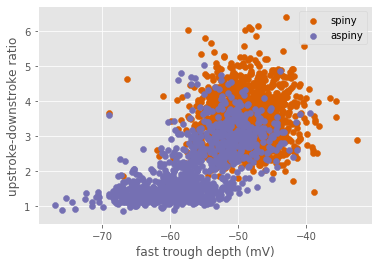

In [23]:
cells = ctc.get_cells()

# we want to add dendrite type as a column to the ephys. features dataframe
# first build an index on cell specimen ID, then create array of dendrite types
cell_index = { c['id']: c for c in cells }
dendrite_types = [ cell_index[cid]['dendrite_type'] if cid in cell_index else "" 
    for cid in ef_df['specimen_id'] ]

# now add the new column
ef_df['dendrite_type'] = pd.Series(dendrite_types, index=ef_df.index)

fig = plt.figure()

for d_type, color in [ ["spiny", "#d95f02"], ["aspiny", "#7570b3"] ]:
    df = ef_df[ef_df['dendrite_type'] == d_type]
    plt.scatter(df['fast_trough_v_long_square'], 
                df['upstroke_downstroke_ratio_long_square'], 
                color=color, label=d_type)

    plt.ylabel("upstroke-downstroke ratio")
    plt.xlabel("fast trough depth (mV)")
    plt.legend(loc='best')
    
plt.show()

## Morphology Features

The Cell Types Database contains a set of precomputed morphological features for cells that have reconstructions.  You can access morphology features by themselves, or combined with the electrophysiology features.

In [11]:
import pandas as pd

# download all morphology features for cells with reconstructions
morphology_features = ctc.get_morphology_features()

# or download both morphology and ephys features
all_features = ctc.get_all_features(require_reconstruction=True)

# convert to a pandas DataFrame
all_features = pd.DataFrame(all_features)
print("All features available for %d cells" % len(all_features))

all_features.head()

All features available for 671 cells


,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,overall_width,scale_factor_x,scale_factor_y,scale_factor_z,soma_surface,superseded,tags,total_length,total_surface,total_volume
0,NaN,134.700000,22.697498,8.335459e-02,1.18768,13.295200,1.025916,-56.375004,-57.385420,-57.431251,...,581.674568,0.1144,0.1144,0.28,444.247484,False,3D Neuron Reconstruction morphology,9995.218601,16666.213729,2355.765059
1,NaN,NaN,-24.887498,-3.913630e-19,1.09984,20.650105,1.025460,-54.000000,-54.828129,-54.656254,...,391.393464,0.1144,0.1144,0.28,1997.534304,False,3D Neuron Reconstruction morphology,6533.385774,13173.179026,2962.024123
2,0.044825,91.322222,-46.761876,2.238637e-01,1.19024,3.826338,1.025363,-44.937504,-43.635419,-47.395833,...,236.976305,0.1144,0.1144,0.28,522.952356,False,3D Neuron Reconstruction morphology,2067.805445,3180.344934,460.354199
3,0.002303,8.756140,-33.787497,6.366711e-01,1.72910,16.728967,1.023988,-60.968754,-63.145835,-66.856253,...,332.948545,0.1144,0.1144,0.28,76.604264,False,3D Neuron Reconstruction morphology,3488.103438,2371.871389,129.985840
4,0.093492,112.245000,3.015000,1.500000e-01,1.10920,5.458287,1.025020,-51.062504,-57.916670,-56.531254,...,374.603996,0.1144,0.1144,0.28,77.936062,False,3D Neuron Reconstruction morphology,2977.161146,2703.134880,204.115177


## Computing Electrophysiology Features

The AllenSDK contains the code used to compute the electrophysiology features you accessed above.  You can run it yourself like this.

In [ ]:
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor

sweep_number = 35
sweep_data = data_set.get_sweep(sweep_number)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

sweep_ext = EphysSweepFeatureExtractor(t=t, v=v, i=i, start=1.02, end=2.02)
sweep_ext.process_spikes()

print("Avg spike threshold: %.01f mV" % sweep_ext.spike_feature("threshold_v").mean())
print("Avg spike width: %.02f ms" %  (1e3 * np.nanmean(sweep_ext.spike_feature("width"))))

The method `spike_feature()` returns a NumPy array of features for each spike. You pass it the name of the feature that you want. Features that can't be calculated for a given spike are set to `NaN`. We can take a look at all the properties calculated for each spike by the extractor:

In [13]:
sweep_ext.spike_feature_keys()

['threshold_index',
 'clipped',
 'threshold_t',
 'threshold_v',
 'threshold_i',
 'peak_index',
 'peak_t',
 'peak_v',
 'peak_i',
 'trough_index',
 'trough_t',
 'trough_v',
 'trough_i',
 'upstroke_index',
 'upstroke',
 'upstroke_t',
 'upstroke_v',
 'downstroke_index',
 'downstroke',
 'downstroke_t',
 'downstroke_v',
 'isi_type',
 'fast_trough_index',
 'fast_trough_t',
 'fast_trough_v',
 'fast_trough_i',
 'adp_index',
 'adp_t',
 'adp_v',
 'adp_i',
 'slow_trough_index',
 'slow_trough_t',
 'slow_trough_v',
 'slow_trough_i',
 'width',
 'upstroke_downstroke_ratio']

We can look at when the spikes occur by looking at the `threshold_t` property (i.e., time of spike threshold).

In [14]:
spike_times = sweep_ext.spike_feature("threshold_t")

print(spike_times[:5])  # print just the first 5 spike times

[1.02811  1.040935 1.053675 1.068645 1.082835]


We can see that the first spikes happen just after the stimulus step begins at 1.02 sec. Let's plot the voltage trace and then put a dot at the time of each spike detected by the extractor.

(0.9, 1.2)

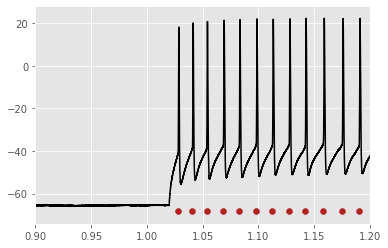

In [15]:
fig = plt.figure()
p = plt.plot(t, v, color='black')

min_v = v.min()

v_level = min_v - 5

plt.scatter(spike_times, np.ones(len(spike_times)) * min_v, c='firebrick')
plt.xlim(0.9, 1.2)

We could also get the threshold voltages from the extractor and put dots where the extractor thinks the spikes begin (zooming in a little more to see better):

(1.015, 1.08)

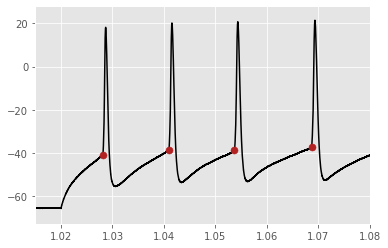

In [16]:
fig = plt.figure()
plt.plot(t, v, color='black')

threshold_v = sweep_ext.spike_feature("threshold_v")

# setting zorder puts the dots on top of the trace
plt.scatter(spike_times, threshold_v, s=50, c='firebrick', zorder=20)
plt.xlim(1.015, 1.08)